<div id="container" style="position:relative;">
<div style="float:left"><h1> Capstone Project Modeling: Funk SVD  </h1></div>
<div style="position:relative; float:right"><img style="height:65px" src ="https://drive.google.com/uc?export=view&id=1EnB0x-fdqMp6I5iMoEBBEuxB_s7AmE2k" />
</div>
</div>

<br>
<br>
<br>


### Camilo Salazar <br> BrainStation <br> November 10, 2023

## Introduction

In this notebook, we delve into the exciting realm of hybrid recommendation systems, a powerful approach that combines the strengths of both collaborative filtering and content-based methods to provide highly personalized book recommendations. By fusing user behavior and content attributes, we aim to create a recommendation model that offers superior accuracy and enhanced user experiences. Join us on this journey as we explore the fusion of data-driven insights and content analysis to bring you a state-of-the-art hybrid book recommender.


In [2]:
# imports usefull libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import random

# import Supriside to run model 
from surprise import Dataset
from surprise.reader import Reader
from surprise.prediction_algorithms.matrix_factorization import SVD as FunkSVD
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise import accuracy

# Filter warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
#loading all dataframes
book_df = pd.read_csv('data_clean/books.csv',index_col=[0])
tags_df = pd.read_csv('data/tags.csv')
book_tags_df = pd.read_csv('data_clean/book_tags.csv',index_col=[0])
ratings_df = pd.read_csv('data/ratings.csv')

---
## Collaborite Filtering Recomender 

In [4]:
# set reader of the rating
reader = Reader(rating_scale=(1, 5))
my_data = Dataset.load_from_df(ratings_df, reader)
trainset, testset = train_test_split(my_data, test_size=.10, random_state = 42)

In [5]:
final_model = FunkSVD( n_factors = 20,
                 n_epochs = 20,
                 lr_all = 0.0075,
                 biased = False,
                 random_state = 42)

final_model.fit(trainset)

In [6]:
book_latent = final_model.qi
book_latent

array([[ 0.32590215,  0.6499362 , -0.89973914, ..., -0.26051843,
        -0.45952262,  0.6313754 ],
       [-0.22880797,  0.28372632, -1.06872092, ..., -0.14884239,
        -0.26380744,  0.868027  ],
       [ 0.79588949,  0.87041907, -0.52657141, ..., -0.03389259,
         0.5858052 ,  0.47999035],
       ...,
       [ 0.32250818,  0.28507686, -0.84495597, ..., -0.45970672,
        -0.26615837,  0.61314426],
       [ 0.53799812, -0.03097239, -1.02789254, ..., -0.28284891,
        -0.25884952,  0.3056886 ],
       [ 0.22194255,  0.25411235, -1.07073524, ..., -0.60164437,
        -0.23986232,  0.53010669]])

In [7]:
book_simind = pd.DataFrame(list(trainset._raw2inner_id_items.items()
),columns=['book_id', 'Vindex']).set_index('book_id', drop=True)
book_simind

,Vindex
book_id,
2757,0
134,1
1463,2
71,3
3339,4
...,...
7636,9995
9080,9996
9980,9997


In [65]:
def id_bookinfo(b_id):
    '''
    Retrieves book information based on a given book ID.

    Parameters
    ----------
    b_id: int
        The book ID (an integer) for the book to retrieve information about. Should be between 1 and 10,000.

    Returns
    -------
    result: pandas.DataFrame
        A DataFrame containing information about the book, including title, authors, and original publication year.
    '''
    # checks that the book id is and int and valid
    if (not isinstance(b_id, int)) or ((b_id < 1) or (b_id > 10000)):
        raise ValueError("Invalid Book Id Pick an Integer between 1-10000")
    
    result = book_df[book_df['book_id'] == b_id][['title', 'authors', 'original_publication_year','average_rating']]
    return result

def title_to_id(b_title):
    '''
    Retrieves the book ID based on a given book title.

    Parameters
    ----------
    b_title: str
        The title of the book to find the corresponding book ID for.

    Returns
    -------
    result: int
        The book ID associated with the given title.
    '''
    
    result = book_df[book_df['title'] == b_title]['book_id']
    return result.values[0]

def vin_to_id(vin, b_ind):
    '''
    Retrieves the book ID based on a given Vindex (index in a similarity matrix).

    Parameters
    ----------
    vin: int
        The Vindex value representing a book's index in a similarity matrix.

    Returns
    -------
    result: int
        The book ID associated with the given Vindex.
    '''
    result = b_ind[b_ind['Vindex'] == vin].index[0]
    return result

 
def id_to_vin(inb, b_ind ):
    '''
    Retrieves the Vindex (index in a similarity matrix) based on a given book ID.

    Parameters
    ----------
    inb: int
        The book ID for which the Vindex is needed.

    Returns
    -------
    result: int
    The Vindex associated with the given book ID
    '''     
    
    result = b_ind.loc[inb][0]
    return result

def title_to_vin(b_title, b_ind):
    '''
    Retrieves the Vindex (index in a similarity matrix) based on a given book title.

    Parameters
    ----------
    b_title: str
        The title of the book for which the Vindex is needed.

    Returns
    -------
    result: int
        The Vindex associated with the given book title.
    '''
        
    result = id_to_vin(title_to_id(b_title),b_ind)
    return result
    
    

In [9]:
from sklearn.metrics.pairwise import cosine_similarity 
coll_similarities = cosine_similarity(book_latent, dense_output=False)

In [57]:
def recomender(b_title, sim_arr, bi):
    '''
    Recommends books similar to a given book title based on book similarities.

    Parameters
    ----------
    b_title: str
        The title of the book for which you want book recommendations.
    book_similarities: np.ndarray
        A 2D numpy array containing book similarities where each row represents a book.
    bi: pd.DataFrame
        A DataFrame containing book indices.

    Returns
    -------
    results: pd.DataFrame
        A DataFrame containing book recommendations and their similarities to the input book.
    '''
    
    # Create a copy of the book indices DataFrame
    botoind = bi.copy()
    # Get the Vindex (index in similarity matrix) of the input book title
    vin = title_to_vin(b_title,bi)
    # Extract similarity data for the input book
    data = sim_arr[vin]
    # Add the Similarities column to the book indices DataFrame
    botoind['Similarities'] = data
    # Sort books by similarity in descending order
    botoind.sort_values('Similarities', ascending=False, inplace=True)
    # Remove the input book from the recommendations
    botoind = botoind.drop(vin_to_id(vin,bi))
    # Get the top 10 book indices
    top10ind = botoind.head(10).index
    results = pd.DataFrame([])
    # Retrieve book information for the top 10 recommended books
    for b_id in top10ind:
        res = id_bookinfo(b_id)
        results = pd.concat([results, res])
    # Add the Similarities column to the recommendations DataFrame
    results['Similarities'] = botoind.head(10)['Similarities'].values
    
    return results


In [58]:
recomender("Words of Radiance (The Stormlight Archive, #2)",coll_similarities,book_simind)

,title,authors,original_publication_year,average_rating,Similarities
561,"The Way of Kings (The Stormlight Archive, #1)",Brandon Sanderson,2010.0,4.64,0.987111
1340,"Golden Son (Red Rising, #2)",Pierce Brown,2015.0,4.46,0.971419
306,"The Wise Man's Fear (The Kingkiller Chronicle,...",Patrick Rothfuss,2011.0,4.57,0.969749
140,The Martian,Andy Weir,2012.0,4.39,0.968499
9140,"The Way of Kings, Part 1 (The Stormlight Archi...",Brandon Sanderson,2011.0,4.67,0.964987
1373,"A Memory of Light (Wheel of Time, #14)","Robert Jordan, Brandon Sanderson",2012.0,4.50,0.964794
1807,"Morning Star (Red Rising, #3)",Pierce Brown,2016.0,4.50,0.963389
1199,"The Alloy of Law (Mistborn, #4)",Brandon Sanderson,2011.0,4.20,0.962975
2888,"Mistborn Trilogy Boxed Set (Mistborn, #1-3)",Brandon Sanderson,2009.0,4.55,0.959330
9523,"The Locket (The Locket, #1)",Richard Paul Evans,1998.0,4.10,0.959034


In [15]:
recomender("The Martian",coll_similarities,book_simind)

,title,authors,original_publication_year,average_rating,Similarities
861,"Words of Radiance (The Stormlight Archive, #2)",Brandon Sanderson,2014.0,4.77,0.968499
7492,Odd and the Frost Giants,"Neil Gaiman, Mark Buckingham",2008.0,3.95,0.968318
4695,"The Defector (Gabriel Allon, #9)",Daniel Silva,2009.0,4.28,0.966090
9216,The Cobra Event,Richard Preston,1997.0,4.00,0.964894
3197,"The Concrete Blonde (Harry Bosch, #3; Harry Bo...",Michael Connelly,1994.0,4.12,0.963949
8707,"Fated (Alex Verus, #1)",Benedict Jacka,2012.0,3.89,0.962762
7497,"The Last Full Measure (The Civil War Trilogy, #3)",Jeff Shaara,1991.0,4.22,0.962293
6171,"Heat Lightning (Virgil Flowers, #2)",John Sandford,2008.0,4.16,0.962248
6719,"Locke & Key, Vol. 4: Keys to the Kingdom","Joe Hill, Gabriel Rodríguez",2011.0,4.44,0.962139
9517,"Counterfeit Gods: The Empty Promises of Money,...",Timothy J. Keller,2009.0,4.32,0.962038


---
## Content Filtering Recomender 

### Genres Content Recomendations

In [25]:
book_df['genres']

0       ['young-adult', 'fiction', 'fantasy', 'science...
1       ['fantasy', 'fiction', 'young-adult', 'classics']
2       ['young-adult', 'fantasy', 'romance', 'fiction...
3       ['classics', 'fiction', 'historical-fiction', ...
4       ['classics', 'fiction', 'historical-fiction', ...
                              ...                        
9995      ['fantasy', 'romance', 'paranormal', 'fiction']
9996               ['biography', 'history', 'nonfiction']
9997                    ['historical-fiction', 'fiction']
9998                         ['nonfiction', 'psychology']
9999      ['history', 'nonfiction', 'historical-fiction']
Name: genres, Length: 10000, dtype: object

In [27]:
import re

def custom_tokenizer(text):
    text = re.sub("[,'\]\[]", ' ', text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    # split sentence into words
    listofwords = text.split()
    return listofwords

s = book_df['genres'][0]

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

text_model = CountVectorizer(tokenizer=custom_tokenizer)

text_pop = text_model.fit_transform(book_df['genres'])

In [29]:
cont_max = pd.DataFrame(columns = text_model.get_feature_names_out(), data = text_pop.toarray())
cont_max

In [47]:
cont1_similarities = cosine_similarity(cont_max, dense_output=False)

In [41]:
tag_ind = book_tag_max.copy()
tag_ind['Vindex'] = range(10000)
tag_ind = tag_ind[['Vindex']]
tag_ind.head()

,Vindex
tag_id,
book_id,
1,0
2,1
3,2
4,3
5,4


In [68]:
recomender("Words of Radiance (The Stormlight Archive, #2)", cont1_similarities, tag_ind)

,title,authors,original_publication_year,average_rating,Similarities
6775,"The Legend of Huma (Dragonlance: Heroes, #1)",Richard A. Knaak,1988.0,4.03,1.0
1904,"Blood Song (Raven's Shadow, #1)",Anthony Ryan,2011.0,4.47,1.0
4005,A Knight of the Seven Kingdoms (The Tales of D...,"George R.R. Martin, Gary Gianni",2013.0,4.19,1.0
1428,"Beyond the Shadows (Night Angel, #3)",Brent Weeks,2008.0,4.29,1.0
5066,"The Dragon Keeper (Rain Wild Chronicles, #1)",Robin Hobb,2009.0,3.93,1.0
858,"The Way of Shadows (Night Angel, #1)",Brent Weeks,2008.0,4.15,1.0
3277,"The Mad Ship (Liveship Traders, #2)",Robin Hobb,1999.0,4.21,1.0
4377,"Promise of Blood (Powder Mage, #1)",Brian McClellan,2013.0,4.16,1.0
3988,The Dark Elf Trilogy Collector's Edition (Forg...,R.A. Salvatore,1998.0,4.33,1.0
9407,"The Darkest Road (The Fionavar Tapestry, #3)",Guy Gavriel Kay,1986.0,4.18,1.0


In [69]:
recomender("Caliban's War (The Expanse, #2)", cont1_similarities, tag_ind)

,title,authors,original_publication_year,average_rating,Similarities
282,Good Omens: The Nice and Accurate Prophecies o...,"Terry Pratchett, Neil Gaiman",1990.0,4.25,1.0
5590,"Virtual Light (Bridge, #1)",William Gibson,1993.0,3.84,1.0
2155,"Red Mars (Mars Trilogy, #1)",Kim Stanley Robinson,1993.0,3.84,1.0
5665,"Excession (Culture, #5)",Iain M. Banks,1996.0,4.19,1.0
3572,"Burning Chrome (Sprawl, #0)","William Gibson, Bruce Sterling",1986.0,4.05,1.0
1336,"Going Postal (Discworld, #33; Moist von Lipwig...",Terry Pratchett,2004.0,4.36,1.0
3631,"Use of Weapons (Culture, #3)",Iain M. Banks,1990.0,4.18,1.0
3643,"On Basilisk Station (Honor Harrington, #1)",David Weber,1992.0,4.11,1.0
5014,"Daughter of the Empire (The Empire Trilogy, #1)","Raymond E. Feist, Janny Wurts",1987.0,4.24,1.0
1728,Seveneves,Neal Stephenson,2015.0,3.98,1.0


### Tag Recomendations

In [16]:
#Reducing number of tags to those that apeear i over 10 books but less than 66% of them 
tag_list = book_tags_df['tag_id'].value_counts()/book_df.shape[0]*100

tag_list = list(tag_list[(tag_list > 0.1) & (tag_list < 66)].index)

book_tags_df2 = book_tags_df[(book_tags_df['tag_id'].isin(tag_list))]

book_tags_df3 = pd.merge(book_tags_df2, book_df[['book_id','goodreads_book_id']] ,on ='goodreads_book_id',how = 'left')

book_tags_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768559 entries, 0 to 768558
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   goodreads_book_id  768559 non-null  int64
 1   tag_id             768559 non-null  int64
 2   count              768559 non-null  int64
 3   book_id            768559 non-null  int64
dtypes: int64(4)
memory usage: 29.3 MB


In [17]:
unq_book = book_tags_df3['goodreads_book_id'].unique()
book_tags_df4 = book_tags_df3.copy()
for i in unq_book:
    max_con = book_tags_df4[book_tags_df4['goodreads_book_id'] == i]['count'].max()
    book_tags_df4.loc[book_tags_df4['goodreads_book_id'] == i,'count'] /= max_con
    
book_tags_df4.tail()

,goodreads_book_id,tag_id,count,book_id
768554,33288638,29299,0.018182,8892
768555,33288638,2101,0.018182,8892
768556,33288638,21303,0.018182,8892
768557,33288638,17271,0.018182,8892
768558,33288638,1126,0.018182,8892


In [18]:
book_tag_max = book_tags_df4.groupby(['book_id','tag_id']).sum().unstack().fillna(0)
book_tag_max.head()

goodreads_book_id                                                  \
tag_id              27    47    71    90    98    115   134   177   190     
book_id                                                                     
1                     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2                     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3                     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4                     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5                     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

               ... count                                                        
tag_id  192    ... 34003 34011 34031 34051 34148 34153 34155 34157 34206 34242  
book_id        ...                                                              
1         0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4         0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5         0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 10280 columns]

In [19]:
from sklearn.preprocessing import StandardScaler

scale_model =  StandardScaler()

scale_m = scale_model.fit_transform(book_tag_max)

In [46]:
cont2_similarities = cosine_similarity(scale_m, dense_output=False)

In [66]:
recomender("Words of Radiance (The Stormlight Archive, #2)", cont2_similarities, tag_ind)

,title,authors,original_publication_year,average_rating,Similarities
561,"The Way of Kings (The Stormlight Archive, #1)",Brandon Sanderson,2010.0,4.64,0.764004
3340,"The Bands of Mourning (Mistborn, #6)",Brandon Sanderson,2016.0,4.45,0.518539
1199,"The Alloy of Law (Mistborn, #4)",Brandon Sanderson,2011.0,4.20,0.515263
2159,"The Blinding Knife (Lightbringer, #2)",Brent Weeks,2012.0,4.45,0.473415
2791,"Shadows of Self (Mistborn, #5)",Brandon Sanderson,2015.0,4.30,0.464496
7992,"Secret History (Mistborn, #3.5)",Brandon Sanderson,2016.0,4.38,0.374148
2977,The Emperor's Soul,Brandon Sanderson,2012.0,4.33,0.342964
3724,"Rise of Empire (The Riyria Revelations, #3-4)",Michael J. Sullivan,2010.0,4.35,0.338344
3797,"Heir of Novron (The Riyria Revelations, #5-6)",Michael J. Sullivan,2012.0,4.46,0.335325
3533,"The Broken Eye (Lightbringer, #3)",Brent Weeks,2014.0,4.46,0.315290


In [48]:
recomender("Caliban's War (The Expanse, #2)", cont2_similarities, tag_ind)

,title,authors,original_publication_year,average_rating,Similarities
3669,"Cibola Burn (The Expanse, #4)",James S.A. Corey,2014.0,4.12,0.674643
4460,"Nemesis Games (The Expanse, #5)",James S.A. Corey,2015.0,4.37,0.579745
2727,"Abaddon's Gate (The Expanse, #3)",James S.A. Corey,2013.0,4.18,0.535179
9033,"Babylon's Ashes (The Expanse, #6)",James S.A. Corey,2016.0,4.18,0.525851
1262,"Leviathan Wakes (The Expanse, #1)",James S.A. Corey,2011.0,4.20,0.468206
5900,Ancillary Mercy (Imperial Radch #3),Ann Leckie,2015.0,4.20,0.279748
6813,"The Human Division (Old Man's War, #5)",John Scalzi,2013.0,4.07,0.270363
6417,The Temporal Void,Peter F. Hamilton,2008.0,4.24,0.267880
6928,Terms of Enlistment (Frontlines #1),Marko Kloos,2013.0,3.96,0.257692
4789,"Authority (Southern Reach, #2)",Jeff VanderMeer,2014.0,3.55,0.253433


--- 
## Hybrid Recomender

In [43]:
def hybrid_recomender(book_title, exclude_author = True):
    """
    Generate book recommendations using a hybrid recommender system.
    
    Parameters:
    - book_title (str): Title of the book for which recommendations are requested.
    - exclude_author (bool): If True, excludes books by the same author from the recommendations.
    
    Returns:
    - DataFrame: Top 10 book recommendations based on a combination of collaborative and content-based filtering.
    """
    # Get the book_id
    book_id = title_to_id(book_title)
    
    # Get indices for collaborative and content-based filtering
    coll_index = id_to_vin(book_id, book_simind)
    cont_index = id_to_vin(book_id, tag_ind)
    
    # Get similarity data
    coll_data = coll_similarities[coll_index]
    cont_data1 = cont2_similarities[cont_index]
    cont_data2 = cont1_similarities[cont_index]
    
    # Create DataFrames for collaborative and content-based filtering
    coll_df = book_simind.copy()
    cont_df = tag_ind.copy()
    
    # Merge the DataFrames
    coll_df['SIM1'] = coll_data
    cont_df['SIM2'] = cont_data1
    cont_df['SIM3'] = cont_data2
    
    merge_df = pd.merge(cont_df, coll_df, on='book_id', how='left')
    merge_df = pd.merge(merge_df, book_df[['book_id', 'average_rating']], on='book_id', how='right').set_index('book_id')
    
    merge_df.columns = merge_df.columns.map(''.join)
    # Calculate the total score
    merge_df['score'] = weight_score(merge_df)
    
    # Exclude books by the same author if specified
    if exclude_author:
        author = book_df[book_df['book_id'] == book_id]['authors'].values[0]
        same_author_ids = list(book_df[book_df['authors'] == author]['book_id'].values)
        merge_df = merge_df.drop(same_author_ids)
    else:
        merge_df = merge_df.drop(book_id)
    
    # Sort and retrieve top 10 recommendations
    merge_df = merge_df.sort_values('score', ascending=False)
    top10_ids = merge_df.head(10).index
    results = pd.DataFrame([])
    
    # Retrieve book information for the top 10 recommended books
    for book_id in top10_ids:
        book_info = id_bookinfo(book_id)
        results = pd.concat([results, book_info])
    
    # Add the 'score' column to the recommendations DataFrame
    results['score'] = merge_df.head(10)['score'].values / 1.325  # Normalize the score
    
    return results

def weight_score(merge_df):
    """
    Calculate the total weighted score for each book in the hybrid recommender system.
    
    Parameters:
    - merge_df (DataFrame): DataFrame containing similarity and rating data for books.
    
    Returns:
    - Series: Total weighted score for each book.
    """
    # Calculate the total weighted score using collaborative and content-based similarities and average rating
    score = merge_df['SIM1'] + 0.25 * merge_df['SIM2'] + 0.05 * merge_df['SIM3'] + 0.005 * merge_df['average_rating']
    
    return score 

In [44]:
hybrid_recomender("Words of Radiance (The Stormlight Archive, #2)")

,title,authors,original_publication_year,average_rating,score
2159,"The Blinding Knife (Lightbringer, #2)",Brent Weeks,2012.0,4.45,0.855968
306,"The Wise Man's Fear (The Kingkiller Chronicle,...",Patrick Rothfuss,2011.0,4.57,0.832913
3797,"Heir of Novron (The Riyria Revelations, #5-6)",Michael J. Sullivan,2012.0,4.46,0.830187
3533,"The Broken Eye (Lightbringer, #3)",Brent Weeks,2014.0,4.46,0.825966
6308,"The Crimson Campaign (Powder Mage, #2)",Brian McClellan,2014.0,4.35,0.807225
3724,"Rise of Empire (The Riyria Revelations, #3-4)",Michael J. Sullivan,2010.0,4.35,0.804137
1340,"Golden Son (Red Rising, #2)",Pierce Brown,2015.0,4.46,0.802357
2605,"The Daylight War (Demon Cycle, #3)",Peter V. Brett,2013.0,4.23,0.799723
6227,"Fool's Quest (The Fitz and The Fool, #2)",Robin Hobb,2015.0,4.53,0.798141
7196,The Providence of Fire (Chronicle of the Unhew...,Brian Staveley,2015.0,4.16,0.796822


In [51]:
hybrid_recomender("Caliban's War (The Expanse, #2)", False)

,title,authors,original_publication_year,average_rating,score
2727,"Abaddon's Gate (The Expanse, #3)",James S.A. Corey,2013.0,4.18,0.955484
3669,"Cibola Burn (The Expanse, #4)",James S.A. Corey,2014.0,4.12,0.937186
4460,"Nemesis Games (The Expanse, #5)",James S.A. Corey,2015.0,4.37,0.935678
7119,"The Dark Forest (Remembrance of Earth’s Past, #2)","Liu Cixin, Joel Martinsen",2008.0,4.38,0.931016
6417,The Temporal Void,Peter F. Hamilton,2008.0,4.24,0.929260
5665,"Excession (Culture, #5)",Iain M. Banks,1996.0,4.19,0.927788
5713,Redemption Ark,Alastair Reynolds,2003.0,4.13,0.923939
9215,"Armageddon's Children (Genesis of Shannara, #1)",Terry Brooks,2006.0,4.09,0.920931
9570,"Dynasty of Evil (Star Wars: Darth Bane, #3)",Drew Karpyshyn,2009.0,4.24,0.917504
7588,"The Vor Game (Vorkosigan Saga, #6)",Lois McMaster Bujold,1990.0,4.28,0.915170


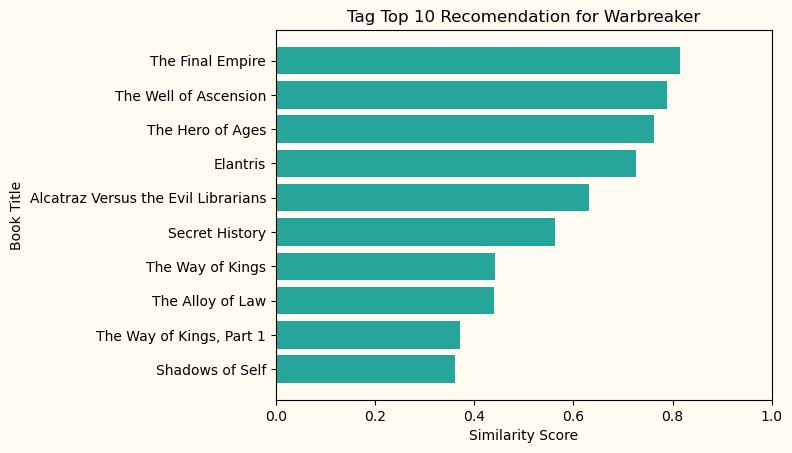

In [123]:
cont_tag = recomender("Warbreaker (Warbreaker, #1)", cont2_similarities, tag_ind).sort_values('Similarities')

plt.figure(facecolor='#fffbf0')
ax = plt.axes()
ax.set_facecolor("#fffbf0")
plt.barh(cont_tag['title'],cont_tag['Similarities'],color = '#26a69a')
plt.yticks(cont_tag['title'],[re.sub("[\(\[].*?[\)\]]", "", x)[:-1] for x in cont_tag['title'].values])
plt.xlim(0,1)
plt.title('Tag Top 10 Recomendation for Warbreaker')
plt.ylabel('Book Title')
plt.xlabel('Similarity Score')
plt.savefig('images/Tag_Recom.png')
plt.show()

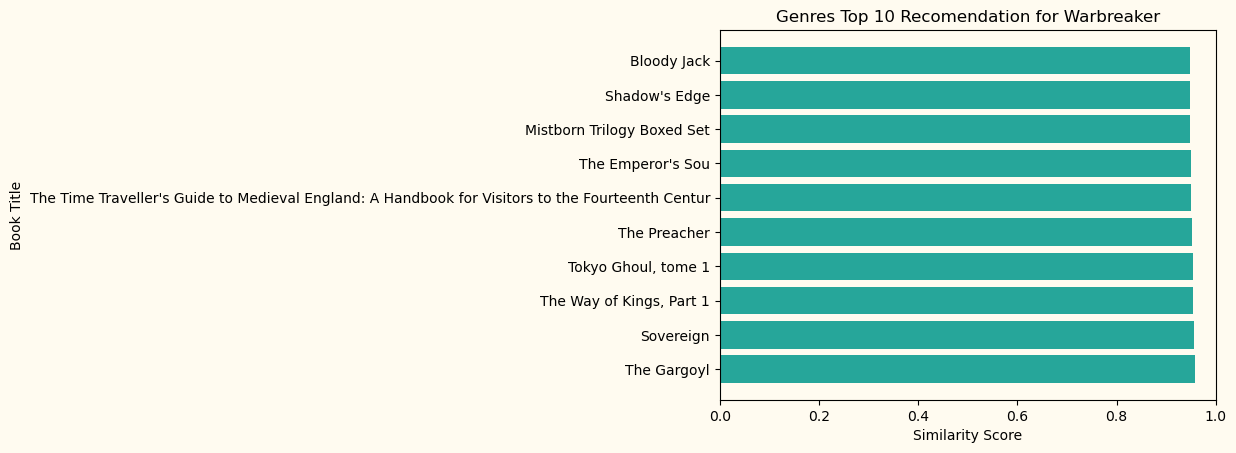

In [135]:
cont_gen =  recomender("Warbreaker (Warbreaker, #1)", coll_similarities, book_simind)

plt.figure(facecolor='#fffbf0')
ax = plt.axes()
ax.set_facecolor("#fffbf0")
plt.barh(cont_gen['title'],cont_gen['Similarities'],color = '#26a69a')
plt.yticks(cont_gen['title'],[re.sub("[\(\[].*?[\)\]]", "", x)[:-1] for x in cont_gen['title'].values])
plt.xlim(0,1)
plt.title('Genres Top 10 Recomendation for Warbreaker')
plt.ylabel('Book Title')
plt.xlabel('Similarity Score')
plt.savefig('images/Gen_Recom.png')
plt.show()

In [134]:
recomender("Warbreaker (Warbreaker, #1)", cont1_similarities, tag_ind)

,title,authors,original_publication_year,average_rating,Similarities
7126,"Kushiel's Scion (Imriel's Trilogy, #1)",Jacqueline Carey,2006.0,4.19,1.0
8591,"Kushiel's Mercy (Imriel's Trilogy, #3)",Jacqueline Carey,2001.0,4.30,1.0
2398,"Naked Empire (Sword of Truth, #8)",Terry Goodkind,2003.0,3.82,1.0
2218,"The Pillars of Creation (Sword of Truth, #7)",Terry Goodkind,2001.0,3.67,1.0
9667,"The Broken Kingdoms (Inheritance, #2)",N.K. Jemisin,2010.0,4.04,1.0
7985,"Kushiel's Justice (Imriel's Trilogy, #2)",Jacqueline Carey,2007.0,4.24,1.0
7324,"Rhapsody: Child of Blood (Symphony of Ages, #1)",Elizabeth Haydon,1999.0,3.95,1.0
1758,"Faith of the Fallen (Sword of Truth, #6)",Terry Goodkind,2000.0,4.11,1.0
1535,"Blood of the Fold (Sword of Truth, #3)",Terry Goodkind,1996.0,3.98,1.0
2644,"Phantom (Sword of Truth, #10)",Terry Goodkind,2006.0,3.99,1.0


In [128]:
cont_gen['Title'] = [re.sub("[\(\[].*?[\)\]]", "", x)[:-1] for x in cont_gen['title'].values]

In [131]:
cont_gen[['Title','authors','average_rating','Similarities']] 

,Title,authors,average_rating,Similarities
7126,Kushiel's Scion,Jacqueline Carey,4.19,1.0
8591,Kushiel's Mercy,Jacqueline Carey,4.30,1.0
2398,Naked Empire,Terry Goodkind,3.82,1.0
2218,The Pillars of Creation,Terry Goodkind,3.67,1.0
9667,The Broken Kingdoms,N.K. Jemisin,4.04,1.0
7985,Kushiel's Justice,Jacqueline Carey,4.24,1.0
7324,Rhapsody: Child of Blood,Elizabeth Haydon,3.95,1.0
1758,Faith of the Fallen,Terry Goodkind,4.11,1.0
1535,Blood of the Fold,Terry Goodkind,3.98,1.0
2644,Phantom,Terry Goodkind,3.99,1.0


In [136]:
recomender("Warbreaker (Warbreaker, #1)", coll_similarities, book_simind)

,title,authors,original_publication_year,average_rating,Similarities
3312,The Gargoyle,Andrew Davidson,2008.0,3.96,0.957592
8282,"Sovereign (Matthew Shardlake, #3)",C.J. Sansom,2006.0,4.28,0.956269
9140,"The Way of Kings, Part 1 (The Stormlight Archi...",Brandon Sanderson,2011.0,4.67,0.954338
5073,"Tokyo Ghoul, tome 1 (Tokyo Ghoul, #1)","Sui Ishida, 石田 スイ",2012.0,4.43,0.953259
5301,"The Preacher (Patrik Hedström, #2)","Camilla Läckberg, Steven T. Murray",2004.0,3.76,0.951169
9992,The Time Traveller's Guide to Medieval England...,Ian Mortimer,2008.0,3.99,0.950950
2977,The Emperor's Soul,Brandon Sanderson,2012.0,4.33,0.949772
2888,"Mistborn Trilogy Boxed Set (Mistborn, #1-3)",Brandon Sanderson,2009.0,4.55,0.948717
1411,"Shadow's Edge (Night Angel, #2)",Brent Weeks,2008.0,4.27,0.948144
6581,"Bloody Jack (Bloody Jack, #1)",L.A. Meyer,2002.0,4.11,0.948143


In [148]:
pic = recomender("Warbreaker (Warbreaker, #1)", cont2_similarities, tag_ind)

pic['Title'] = [re.sub("[\(\[].*?[\)\]]", "", x) for x in pic['title'].values]
pic[['Title','authors','average_rating','Similarities']] 

,Title,authors,average_rating,Similarities
388,The Final Empire,Brandon Sanderson,4.43,0.815300
564,The Well of Ascension,Brandon Sanderson,4.35,0.789169
602,The Hero of Ages,Brandon Sanderson,4.46,0.762356
1048,Elantris,Brandon Sanderson,4.17,0.726425
8372,Alcatraz Versus the Evil Librarians,Brandon Sanderson,3.87,0.631602
7992,Secret History,Brandon Sanderson,4.38,0.562777
561,The Way of Kings,Brandon Sanderson,4.64,0.441816
1199,The Alloy of Law,Brandon Sanderson,4.20,0.440695
9140,"The Way of Kings, Part 1",Brandon Sanderson,4.67,0.371629
2791,Shadows of Self,Brandon Sanderson,4.30,0.361596
